In [38]:
import geopandas as gpd
import json
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from epitools import get_data

In [65]:
election_year = 2021
election_round = "general"
country = "Germany"
aggregation = "nuts_3"

df = pd.read_csv(f"data_output/{country}/{election_year}_{election_round}.csv.gz")
df_location = pd.read_csv(f"data_output/{country}/{election_year}_{election_round}_location.csv.gz")

if "flag_candidates" in list(df):
    df = df.query("flag_candidates == 1")

df = pd.merge(df, df_location, on="polling_id")
df[aggregation] = df[aggregation].astype(str)

print(df.shape)
print(f"Nro. candidates: {len(df.candidate.unique())}")
print(df.candidate.unique())


(4166536, 11)
Nro. candidates: 44
['CDU' 'SPD' 'AfD' 'FDP' 'DIE LINKE' 'GRÜNE' 'CSU' 'FREIE WÄHLER'
 'Die PARTEI' 'Tierschutzpartei' 'NPD' 'PIRATEN' 'ÖDP' 'V-Partei³' 'DiB'
 'BP' 'Tierschutzallianz' 'MLPD' 'Gesundheitsforschung' 'MENSCHLICHE WELT'
 'DKP' 'Die Grauen' 'BüSo' 'Die Humanisten' 'Gartenpartei' 'du.'
 'dieBasis' 'Bündnis C' 'BÜRGERBEWEGUNG' 'III. Weg' 'Bündnis21' 'LIEBE'
 'LKR' 'SSW' 'Team Todenhöfer' 'UNABHÄNGIGE' 'Volt' 'Volksabstimmung' 'B*'
 'sonstige' 'FAMILIE' 'Graue Panther' 'KlimalisteBW' 'THP']


In [66]:
df_ep = get_data(
    country=country,
    year=election_year,
    aggregation=aggregation,
    election=election_round
)
df_ep[aggregation] = df_ep[aggregation].astype(str)
df_ep.head()

,nuts_3,ec,ep,year
0,DE111,0.850676,0.042203,2021
1,DE112,0.872121,0.023239,2021
2,DE113,0.869008,0.025390,2021
3,DE114,0.871163,0.028290,2021
4,DE115,0.870485,0.027010,2021


In [67]:
data = df.groupby([aggregation, "candidate"]).agg({"value": "sum"})
data["rank"] = data.groupby(level=0)["value"].rank("min", ascending=False).astype(int)
data = data.reset_index()
data.head()

,nuts_3,candidate,value,rank
0,DE111,AfD,15898,5
1,DE111,B*,0,17
2,DE111,BP,0,17
3,DE111,BÜRGERBEWEGUNG,533,12
4,DE111,BüSo,62,16


In [68]:
gdf = gpd.read_file("geo_shapes/NUTS_RG_20M_2021_3035.shp.zip").to_crs("epsg:4326")
gdf = gdf.rename(columns={"NUTS_ID": aggregation})
gdf[aggregation] = gdf[aggregation].astype(str)
gdf = gdf[~gdf[aggregation].str.contains("FRY")]
gdf.head()

,nuts_3,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry
0,FR,0,FR,France,France,0.0,0,0,FR,"MULTIPOLYGON (((55.21471 -21.03851, 55.27392 -..."
1,HR,0,HR,Hrvatska,Hrvatska,0.0,0,0,HR,"MULTIPOLYGON (((16.59681 46.47590, 16.85476 46..."
2,HU,0,HU,Magyarország,Magyarország,0.0,0,0,HU,"POLYGON ((22.12108 48.37831, 22.15531 48.40340..."
3,AL,0,AL,Shqipëria,Shqipëria,0.0,0,0,AL,"POLYGON ((19.83100 42.46645, 20.07630 42.55582..."
4,AT,0,AT,Österreich,Österreich,0.0,0,0,AT,"POLYGON ((15.75363 48.85218, 16.29009 48.73395..."


In [ ]:
gdf = gpd.read_file(f"geo_shapes/{country}/{aggregation}.geojson")
gdf[aggregation] = gdf[aggregation].astype(str)
gdf.head()

,fid,objectid,cir_sena,region_id,area_km,st_area_sh,st_length_,Region,geometry
0,1,1084,1,15,16866.8198,1.886869e+10,7.505296e+05,Región de Arica y Parinacota,"POLYGON ((-69.41530 -17.65520, -69.33660 -17.7..."
1,2,1085,2,1,42284.5674,4.830637e+10,1.213713e+06,Región de Tarapacá,"MULTIPOLYGON (((-70.16030 -20.21070, -70.16020..."
2,3,1086,3,2,126071.4319,1.508452e+11,2.516112e+06,Región de Antofagasta,"MULTIPOLYGON (((-70.70160 -25.89170, -70.70050..."
3,4,1087,15,12,133053.1423,3.581316e+11,9.049830e+07,Región de Magallanes y Antártica Chilena,"MULTIPOLYGON (((-67.32020 -55.92010, -67.24870..."
4,5,1088,14,11,106703.3773,2.242743e+11,4.144481e+07,Región de Aysén del Gral.Ibañez del Campo,"MULTIPOLYGON (((-75.57990 -48.75890, -75.58030..."


In [69]:
colors = open("colors.json", "rb")
colors = json.loads(colors.read())

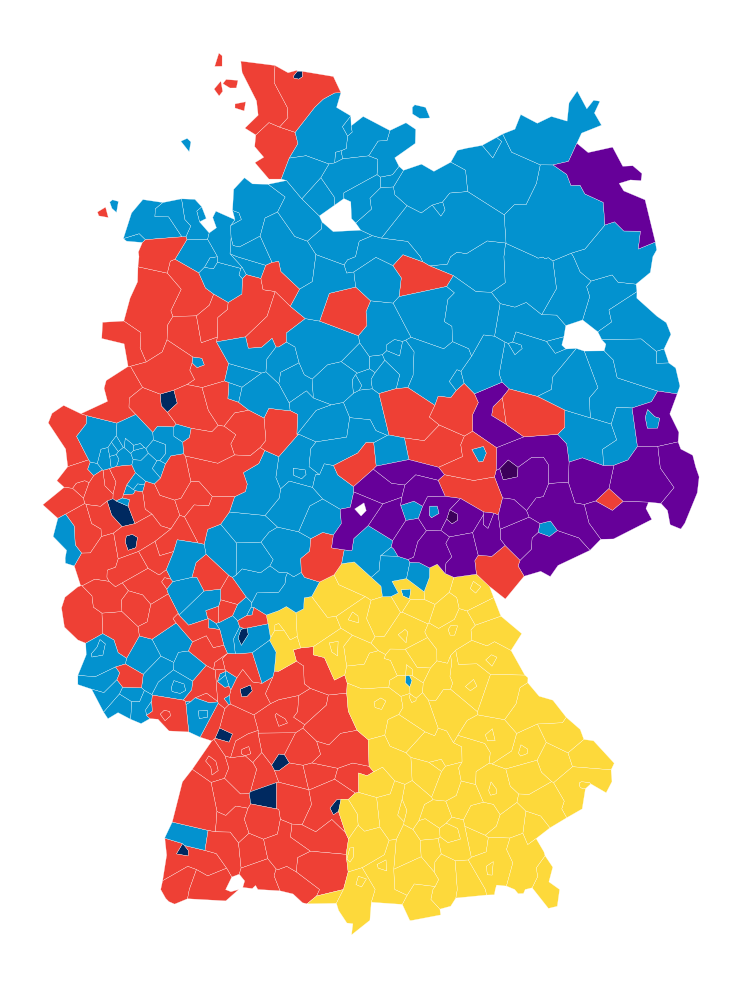

In [70]:
visdata = pd.merge(
    data.query("rank == 1"),
    gdf,
    on=aggregation
)

visdata = pd.merge(
    visdata,
    df_ep,
    on=aggregation
)

ckey = f"{country}_{election_year}"
if ckey in colors:
    visdata["color"] = visdata["candidate"].replace(colors[ckey])
else:
    rnd_clrs = 	["#002960", "#ee4035", "#0392cf", "#fdd93b", "#660099", "#3d005b"]
    rnd_cnds = list(visdata["candidate"].unique())
    visdata["color"] = visdata["candidate"].apply(lambda x: rnd_clrs[rnd_cnds.index(x)])

visdata = gpd.GeoDataFrame(visdata)

fig, ax = plt.subplots(figsize=(10, 10))

visdata.plot(
    color=visdata["color"],
    linewidth=0.2,
    edgecolor="#FFF",
    ax=ax
)

ax.axis("off")
fig.tight_layout()

(5.419798212102953, 15.480107543451657, 46.88451403815431, 55.36771311517096)

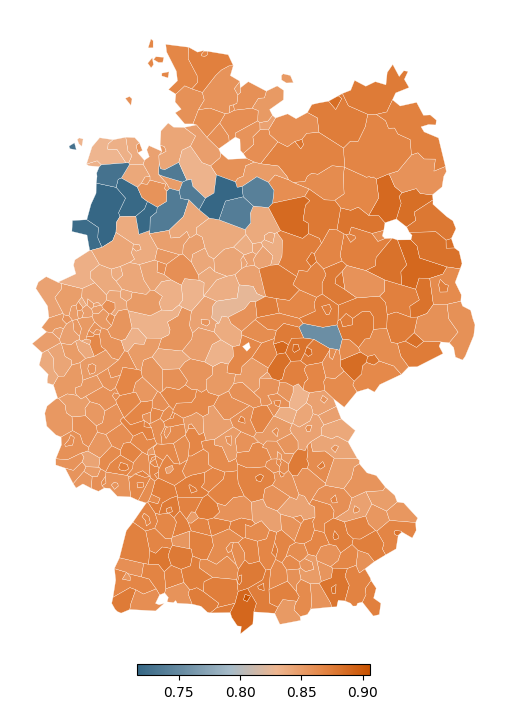

In [72]:
fig, ax = plt.subplots(figsize=(10, 10))

clrs = ["#c85200", "#e48646", "#eeb690", "#a6bbc8", "#6b8ea4", "#366785"]
clrs.reverse()

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", clrs)

visdata.plot(
    column="ec",
    linewidth=0.2,
    edgecolor="#FFF",
    cmap=cmap,
    legend=True,
    ax=ax,
    legend_kwds={"location": "bottom", "shrink": 0.3, "pad": 0}
)

ax.axis("off")